In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [2]:
df_calendar = pd.read_csv('./data/calendar.csv')
df_listings = pd.read_csv('./data/listings.csv')
df_reviews = pd.read_csv('./data/reviews.csv')

df_calendar.shape, df_listings.shape, df_reviews.shape

((1393570, 4), (3818, 92), (84849, 6))

## 1. Which month has the highest number of available listings?

In [3]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
df_calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [5]:
df_calendar.isna().mean() #check if there is any missing value in the dataset

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

In [6]:
df_calendar.groupby('listing_id').count() #count the number of data for each listing in the calendar dataframe

,date,available,price
listing_id,,,
3335,365,365,309
4291,365,365,365
5682,365,365,309
6606,365,365,365
7369,365,365,53
...,...,...,...
10332096,365,365,365
10334184,365,365,361
10339144,365,365,0


In [7]:
df_calendar.groupby('listing_id').count()['date'].mean() #check how many dates are available for each listing

365.0

In [8]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'], format="%Y/%m/%d") #convert date object to datatime type

In [9]:
df_calendar.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                 object
dtype: object

In [10]:
df_calendar.groupby('listing_id').date.min()

listing_id
3335       2016-01-04
4291       2016-01-04
5682       2016-01-04
6606       2016-01-04
7369       2016-01-04
              ...    
10332096   2016-01-04
10334184   2016-01-04
10339144   2016-01-04
10339145   2016-01-04
10340165   2016-01-04
Name: date, Length: 3818, dtype: datetime64[ns]

In [11]:
df_calendar.groupby('listing_id').date.min().dt.date.duplicated(keep=False).mean() #check if all listing has the same start date

1.0

In [12]:
df_calendar.groupby('listing_id').date.max()

listing_id
3335       2017-01-02
4291       2017-01-02
5682       2017-01-02
6606       2017-01-02
7369       2017-01-02
              ...    
10332096   2017-01-02
10334184   2017-01-02
10339144   2017-01-02
10339145   2017-01-02
10340165   2017-01-02
Name: date, Length: 3818, dtype: datetime64[ns]

In [13]:
df_calendar.groupby('listing_id').date.max().dt.date.duplicated(keep=False).mean() #check if all listing has the same end date

1.0

In [14]:
# Split the date into year, month, date and add extra columns for each of them
df_calendar['year'] = df_calendar['date'].dt.year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['day'] = df_calendar['date'].dt.day

In [15]:
df_calendar.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                 object
year                   int64
month                  int64
day                    int64
dtype: object

In [16]:
# Choose only the available listings
df_available_listing = df_calendar[df_calendar.available=='t'].copy()
df_available_listing_counts = df_available_listing.groupby('month').count()
df_available_listing_counts

,listing_id,date,available,price,year,day
month,,,,,,
1,64937,64937,64937,64937,64937,64937
2,73321,73321,73321,73321,73321,73321
3,83938,83938,83938,83938,83938,83938
4,76037,76037,76037,76037,76037,76037
5,79971,79971,79971,79971,79971,79971
6,77244,77244,77244,77244,77244,77244
7,74222,74222,74222,74222,74222,74222
8,76347,76347,76347,76347,76347,76347
9,77246,77246,77246,77246,77246,77246


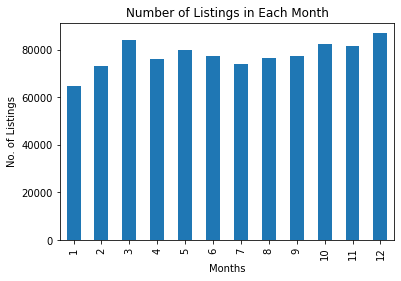

In [17]:
# Group the available listings by month and plot the number of listings in each month in a bar chart
ax = df_available_listing_counts.plot.bar(y='listing_id', legend=False)
ax.set_xlabel('Months');
ax.set_ylabel('No. of Listings');
ax.set_title('Number of Listings in Each Month');

## 2. How does number of available listings relate with price?

In [18]:
df_available_listing['price'].isna().mean() #check if each available listing has a price.

0.0

In [19]:
#convert price object to integer
df_available_listing.loc[:, 'price'] = df_available_listing['price'].replace('[\$\,]|\.\d*', '', regex=True).astype(int)
df_available_listing

,listing_id,date,available,price,year,month,day
0,241032,2016-01-04,t,85,2016,1,4
1,241032,2016-01-05,t,85,2016,1,5
9,241032,2016-01-13,t,85,2016,1,13
10,241032,2016-01-14,t,85,2016,1,14
14,241032,2016-01-18,t,85,2016,1,18
...,...,...,...,...,...,...,...
1393207,10208623,2016-01-06,t,87,2016,1,6
1393208,10208623,2016-01-07,t,87,2016,1,7
1393211,10208623,2016-01-10,t,87,2016,1,10
1393212,10208623,2016-01-11,t,87,2016,1,11


In [20]:
def cal_months_avg_price(df):
    """
    This function is used to calculate the average price for each listing in each month.
    
    Parameters:
    df - Pandas DataFrame which contains all listings with respective price and month as integer
    
    return:
    df_result - A Pandas Dataframe which contains the listing_id and its average price in all months
    months_list - A list of months detected in the df
    
    """
    # Create list of listing_ids and months in df
    listings_list = list(set(df['listing_id']))
    months_list = list(set(df['month']))
    
    # intialization of variables
    avg_price_list = np.zeros((len(listings_list),12))
    row_count = 0;
    col_count = 0;
    
    # for each listing_id, select a certain month and compute its mean
    for month in months_list:
        for listing in listings_list:
            sel_listing = df['listing_id'] == listing
            sel_month = df['month'] == month

            if (df[sel_listing & sel_month].empty != False):
                avg_price_list[row_count, col_count] = np.NaN
            else:
                avg_price_list[row_count, col_count] = df[sel_listing & sel_month].price.mean()
            
            row_count += 1
            
        col_count += 1
        row_count = 0
        
    # Output results in a data frame
    d = {'listing_id': listings_list, 'Jan': avg_price_list[:, 0],
        'Feb': avg_price_list[:, 1],
        'March': avg_price_list[:, 2],
        'April': avg_price_list[:, 3],
        'May': avg_price_list[:, 4],
        'June': avg_price_list[:, 5],
        'July': avg_price_list[:, 6],
        'Aug': avg_price_list[:, 7],
        'Sep': avg_price_list[:, 8],
        'Oct': avg_price_list[:, 9],
        'Nov': avg_price_list[:, 10],
        'Dec': avg_price_list[:, 11]}
    
    df_result = pd.DataFrame(data=d).round(2)
    df_result = df_result.set_index('listing_id')


    return df_result, months_list

In [21]:
df_month_avg_price, months_list = cal_months_avg_price(df_available_listing)
df_month_avg_price.head()

,Jan,Feb,March,April,May,June,July,Aug,Sep,Oct,Nov,Dec
listing_id,,,,,,,,,,,,
8953857,129.00,NaN,NaN,138.33,137.39,137.0,136.1,155.16,135.0,134.81,134.33,135.45
2727938,91.25,85.00,87.56,99.47,110.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598023,99.00,99.00,99.00,99.00,99.00,99.0,99.0,99.00,99.0,99.00,99.00,99.00
794633,114.58,100.17,107.81,136.20,191.74,198.0,198.0,198.00,198.0,198.00,198.00,198.00
958475,85.00,85.00,85.00,85.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.00


In [22]:
df_month_avg_price.shape, months_list

((3723, 12), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

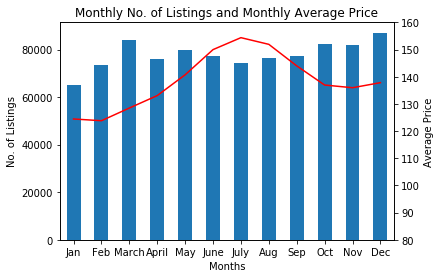

In [23]:
ax = df_available_listing_counts.plot.bar(y='listing_id', style='b', legend=False)
df_month_avg_price.mean(axis=0, skipna=True).plot(ax=ax, style='r', legend=False, secondary_y=True)
ax.set_xlabel('Months');
ax.set_ylabel('No. of Listings');
ax.right_ax.set_ylabel('Average Price')
ax.right_ax.set_yticks([80, 90, 100, 110, 120, 130, 140, 150, 160])
ax.set_title('Monthly No. of Listings and Monthly Average Price');